<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Qtensor-vs-other-simulators:-speed" data-toc-modified-id="Qtensor-vs-other-simulators:-speed-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Qtensor vs other simulators: speed</a></span><ul class="toc-item"><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Plot-comparisons" data-toc-modified-id="Plot-comparisons-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Plot comparisons</a></span></li></ul></li></ul></div>

# Qtensor vs other simulators: speed

The functions from this notebook are exported and invoken on a remote server.

The data that is generated is transferred back to local machine and plotted here as well

## Generate data

In [1]:
#export
import numpy as np
import qtensor as qt
from qtensor.tests.qiskit_qaoa_energy import simulate_qiskit_amps
from qtensor.tests.qaoa_quimb import simulate_one_parallel as simulate_quimb_energy
import matplotlib.pyplot as plt
import time

from cartesian_explorer import Explorer

%load_ext autoreload
%autoreload 2

/home/dali/git-bulit/cotengra/cotengra/hyper.py:18: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


In [2]:
#export
ex = Explorer()

In [3]:
#export    
@ex.provider
def graph(N, d=3, graph_type='random', seed=10):
    return qt.toolbox.random_graph(nodes=N, type=graph_type, degree=d, seed=seed)

In [4]:
#export
@ex.provider
def qiskit_time(graph, p):
    gamma, beta = [.1]*p, [.3]*p
    start = time.time()
    try:
        _ = simulate_qiskit_amps(graph, gamma, beta)
    except:
        return None
    end = time.time()
    return end - start

In [5]:
qis_time = ex.get_variable('qiskit_time', N=10, p=2)
print(qis_time)

INFO:qiskit.transpiler.runningpassmanager:Pass: Unroller - 11.50870 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: RemoveResetInZeroState - 0.08631 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Unroller - 22.08233 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: RemoveResetInZeroState - 0.13542 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Depth - 10.57553 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: FixedPoint - 0.02241 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 10.33092 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CXCancellation - 2.99215 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Depth - 12.59089 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: FixedPoint - 0.02003 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 7.63345 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CXCancellation - 5.46932 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Depth - 11.14202 (ms)
INFO:qisk

0.3324861526489258


In [6]:
#export
@ex.provider
def quimb_time(graph, p,
               n_processes=2,
               qmb_optimizer_time=0.3,
               qmb_ordering_algo='uniform'
              ):
    start = time.time()
    try:
        _ = simulate_quimb_energy(graph, p,
                                  n_processes=n_processes,
                                  optimizer_time=qmb_optimizer_time,
                                  ordering_algo=qmb_ordering_algo
                                 )
    except:
        return None
    end = time.time()
    return end - start

In [7]:
qis_time = ex.get_variable('quimb_time', N=10, p=2)
print(qis_time)


3.1466901302337646


In [30]:
#export
@ex.provider
def qtensor_time(graph, p,
               n_processes=2,
               qtn_ordering_algo='greedy'
              ):
    gamma, beta = [.1]*p, [.3]*p
    opt = qt.toolbox.get_ordering_algo(qtn_ordering_algo)
    sim = qt.QAOAQtreeSimulator(qt.DefaultQAOAComposer, optimizer=opt)
    start = time.time()
    try:
        _ = sim.energy_expectation_parallel(graph, gamma, beta, n_processes=n_processes)
    except:
        return None
    end = time.time()
    return end - start

In [31]:
qis_time = ex.get_variable('qtensor_time', N=10, p=2)
print(qis_time)


0.3359358310699463


## Generate data

In [38]:
def gen_time_data(Ns, ps):
    xar = ex.get_variables_xarray(
        ('qtensor_time', 'quimb_time', 'qiskit_time'),
        p=ps,
        N=Ns,
    )
    return xar

In [40]:
Ns = 2**(np.arange(2, 7))
ps = [2, 3, 4]
xar = gen_time_data(Ns, ps)
xar

<xarray.DataArray (varname: 3, p: 3, N: 5)>
array([[[0.1986532211303711, 0.23852086067199707, 0.3875243663787842,
         0.9208042621612549, 2.2851364612579346],
        [0.25737977027893066, 0.2925271987915039, 0.5027916431427002,
         2.3330559730529785, 5.36878228187561],
        [0.23247385025024414, 0.5181341171264648, 1.5096356868743896,
         None, None]],

       [[1.4637951850891113, 2.61000919342041, 5.22974705696106,
         11.11734938621521, 23.87983512878418],
        [1.4567959308624268, 2.997959852218628, 5.777643442153931,
         14.110242128372192, 40.06003379821777],
        [1.931410312652588, 3.532111167907715, None, None, None]],

       [[0.12799739837646484, 0.32088565826416016, 3.7475616931915283,
         None, None],
        [0.2068026065826416, 0.34174299240112305, 3.357203960418701,
         None, None],
        [0.3334531784057617, 0.4718747138977051, 4.8360371589660645,
         None, None]]], dtype=object)
Coordinates:
  * varname  (varname) <U12 'qtensor_time' 'quimb_time' 'qiskit_time'
  * p        (p) int64 2 3 4
  * N        (N) int64 4 8 16 32 64

## Plot comparisons


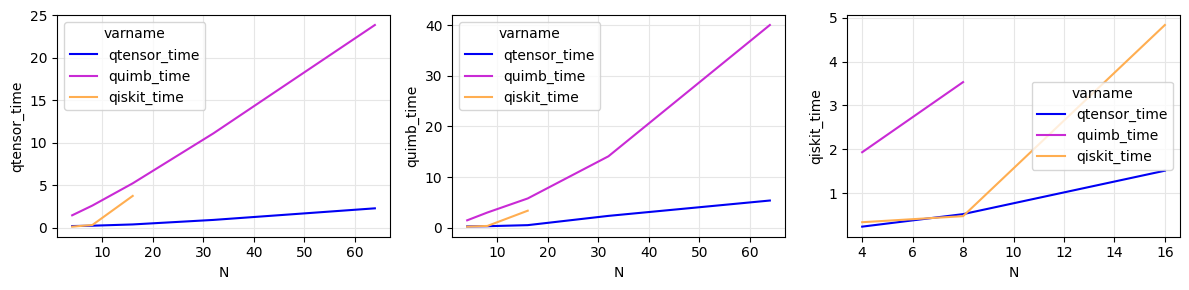

In [54]:
xar_tr = xar.transpose('p', 'varname', 'N')
#xar_tr = xar_tr.rename({'varname':'lib'})
fig = ex.plot_xarray(xar_tr)

In [65]:
def plot_xar_data(xar_orig):
    xar = xar_orig.transpose('p', 'varname', 'N')
    def custom_plot(x, y, **kwargs):
        plt.plot(x, y, '*-', **kwargs)
        plt.yscale('log')
        plt.xscale('log', base=2)
    fig = ex.plot_xarray(xar, plot_func=custom_plot)

    axes = fig.axes
    axes[0].get_shared_y_axes().join(*axes)
    axes[0].get_shared_x_axes().join(*axes)
    ps = [x.data for x in xar.coords['p']]

    [ax.autoscale() for ax in axes]
    [ax.set_title(x) for ax, x in zip(axes, [f"p = {p}" for p in ps])]


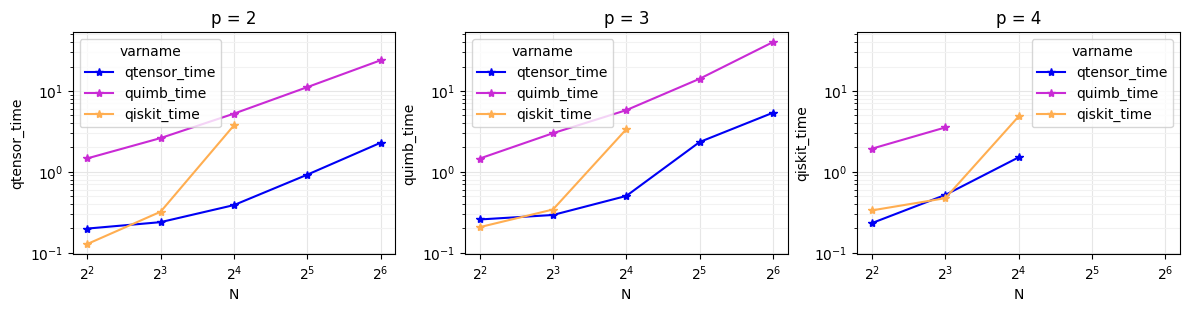

In [66]:
plot_xar_data(xar)

In [1]:
#hide
#default_exp speed_comparison

from nbdev.export  import *
notebook2script(fname='Speed_comparison.ipynb')

NotJSONError: Notebook does not appear to be JSON: '{\n "cells": [\n  {\n   "cell_type": "m...